#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from google.colab.data_table import DataTable
DataTable.max_columns = 60

# Logistic Regression

*   Compare Logistic Regression (Vanilla), Logistic Regression with L1 Regularization and Logistic Regression with L2 Regularization (No feature selection)
*   Compare logistic regression with and without feature selection (forward & backward)



In [23]:
# PyTorch package and submodules
import torch
import torch.nn as nn
from torch.optim import SGD #gradient descent optimizer

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

# We use AUROC and average precision (AP) scores from sklearn
from sklearn.metrics import roc_auc_score, average_precision_score

In [24]:
# We convert dataframe to numpy array to PyTorch tensor datatype for training dataframe
X_train = torch.tensor(X_df_SMOTE.to_numpy(),dtype=torch.float32)
m,n = X_train.shape
y_train = torch.tensor(y_df_SMOTE.to_numpy(),dtype=torch.float32).reshape(m,1)

# for test dataframe
X_test = torch.tensor(X_df_Test.to_numpy(),dtype=torch.float32)
m,n = X_test.shape
y_test = torch.tensor(y_df_Test.to_numpy(),dtype=torch.float32).reshape(m,1)

We first fit an ordinary logistic regression model as a baseline. We will use AUROC and average precision (AP) scores to test model performance.

In [25]:
h = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f = torch.nn.Sequential(
    h,
    sigma
)

J_BCE = torch.nn.BCELoss()
# We use the Adam optimizer, which is a variant of gradient descent method with momentum.
# Adam optimizer is a special gradient descent method with an automatic adaptation of learning rate
# so it converges at a faster rate

# parameters that they will optimize are all the parameters
GD_optimizer = torch.optim.Adam(lr=0.01,params=f.parameters())

nIter = 5000
printInterval = 500

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f(X_train)
    loss = J_BCE(pred,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f(X_test)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.737
Iter 500: average BCE loss is 0.568
Iter 1000: average BCE loss is 0.560
Iter 1500: average BCE loss is 0.559
Iter 2000: average BCE loss is 0.559
Iter 2500: average BCE loss is 0.559
Iter 3000: average BCE loss is 0.559
Iter 3500: average BCE loss is 0.559
Iter 4000: average BCE loss is 0.559
Iter 4500: average BCE loss is 0.559
Iter 5000: average BCE loss is 0.559
On test dataset: AUROC 0.731, AP 0.181


In [26]:
weight = h.weight.detach().squeeze().clone()

We will perform a logistic regression model with L2 regularization. We will use AUROC and average precision (AP) scores to test model performance.



In [27]:
h_L2 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid (with regularization)
f_L2 = torch.nn.Sequential(
    h_L2,
    sigma
)

J_BCE = torch.nn.BCELoss()

# PyTorch optimizer support L2 regularization by
# setting the weight_decay parameter, which corresponds to
# the regularization strength
GD_optimizer = torch.optim.Adam(lr=0.01,params=f_L2.parameters(),weight_decay=0.05)

nIter = 1000
printInterval = 50

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f_L2(X_train)
    loss = J_BCE(pred,y_train)
    loss.backward()
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f_L2(X_test)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.715
Iter 50: average BCE loss is 0.656
Iter 100: average BCE loss is 0.644
Iter 150: average BCE loss is 0.641
Iter 200: average BCE loss is 0.640
Iter 250: average BCE loss is 0.640
Iter 300: average BCE loss is 0.640
Iter 350: average BCE loss is 0.640
Iter 400: average BCE loss is 0.640
Iter 450: average BCE loss is 0.640
Iter 500: average BCE loss is 0.640
Iter 550: average BCE loss is 0.640
Iter 600: average BCE loss is 0.640
Iter 650: average BCE loss is 0.640
Iter 700: average BCE loss is 0.640
Iter 750: average BCE loss is 0.640
Iter 800: average BCE loss is 0.640
Iter 850: average BCE loss is 0.640
Iter 900: average BCE loss is 0.640
Iter 950: average BCE loss is 0.640
Iter 1000: average BCE loss is 0.640
On test dataset: AUROC 0.735, AP 0.201


In [28]:
weight_L2 = h_L2.weight.detach().squeeze().clone()

We will perform a logistic regression model with L1 regularization. We will use AUROC and average precision (AP) scores to test model performance.



In [29]:
h_L1 = torch.nn.Linear(
    in_features=n,
    out_features=1,
    bias=True
)
sigma = torch.nn.Sigmoid()

# Logistic model is linear+sigmoid
f_L1 = torch.nn.Sequential(
    h_L1,
    sigma
)

J_BCE = torch.nn.BCELoss()

GD_optimizer = torch.optim.Adam(lr=0.01,params=f_L1.parameters())

# Define L_1 regularization
def L1_reg(model,lbd):
    result = torch.tensor(0)
    for param in model.parameters(): # iterate over all parameters of our model
        result = result + param.abs().sum()

    return lbd*result


nIter = 1000
printInterval = 50
lbd = 0.03 # L1 reg strength

for i in range(nIter):
    GD_optimizer.zero_grad()
    pred = f_L1(X_train)
    loss = J_BCE(pred,y_train)
    (loss+L1_reg(f_L1,lbd)).backward() #backward calculates differentiation
    GD_optimizer.step()
    if i == 0 or ((i+1)%printInterval) == 0:
        print('Iter {}: average BCE loss is {:.3f}'.format(i+1,loss.item()))

with torch.no_grad():
    pred_test = f_L1(X_test)

auroc = roc_auc_score(y_test,pred_test)
ap = average_precision_score(y_test,pred_test)
print('On test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Iter 1: average BCE loss is 0.723
Iter 50: average BCE loss is 0.672
Iter 100: average BCE loss is 0.660
Iter 150: average BCE loss is 0.652
Iter 200: average BCE loss is 0.648
Iter 250: average BCE loss is 0.646
Iter 300: average BCE loss is 0.646
Iter 350: average BCE loss is 0.646
Iter 400: average BCE loss is 0.645
Iter 450: average BCE loss is 0.646
Iter 500: average BCE loss is 0.646
Iter 550: average BCE loss is 0.646
Iter 600: average BCE loss is 0.645
Iter 650: average BCE loss is 0.646
Iter 700: average BCE loss is 0.646
Iter 750: average BCE loss is 0.645
Iter 800: average BCE loss is 0.646
Iter 850: average BCE loss is 0.646
Iter 900: average BCE loss is 0.645
Iter 950: average BCE loss is 0.645
Iter 1000: average BCE loss is 0.646
On test dataset: AUROC 0.703, AP 0.154


In [30]:
weight_L1 = h_L1.weight.detach().squeeze().clone()

Let us now visualize and compare the weights of the three models.

In [31]:
weight_df = pd.DataFrame(
    {
        'Baseline':weight,
        'L2':weight_L2,
        'L1':weight_L1
    }
).melt(id_vars=[],value_vars=['Baseline','L2','L1'])
weight_df

,variable,value
0,Baseline,-0.022154
1,Baseline,-0.270356
2,Baseline,0.398880
3,Baseline,0.688782
4,Baseline,-0.595731
...,...,...
64,L1,0.000752
65,L1,0.003025
66,L1,-0.000395
67,L1,0.912685


In [32]:
#scatter plot and box plot to show the distribution of the parameters
# Baseline the parameters are bigger compared to the L2 and L1 regularization
# L1 & L2 effectively reduced the range of the parameters

fig = px.box(
    weight_df,
    y='value',
    facet_col='variable',
    color='variable',
    points='all',
    title='Logistic Regression Weights Distributions'
)
fig.update_yaxes(
    matches=None,
    showticklabels=True
)
fig.update_traces(jitter=0.5)

Feature Selection (Forward & Backward)


In [33]:
from sklearn.linear_model import LogisticRegression as logit # use build-in logistic regression model in sklearn
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

In [34]:
#logit is the logistic regression model in sklearn that we imported, solver is how you want the model to be solved
model = logit(solver='liblinear')

# Forward feature selection. Inputs(model name,number of features to select, direction)
forward_selection = SFS(
    model, n_features_to_select=3, direction="forward"
).fit(X_df_SMOTE, np.ravel(y_df_SMOTE)) #fit on the training part of the dataset

# Backward feature selection.
backward_selection = SFS(
    model, n_features_to_select=3, direction="backward"
).fit(X_df_SMOTE, np.ravel(y_df_SMOTE))



In [35]:
forward_selection.get_feature_names_out() #check which features got selected

array(['mbp_max', 'sofa_respiration', 'sofa_cns'], dtype=object)

In [36]:
backward_selection.get_feature_names_out()

array(['sofa_respiration', 'sofa_cns', 'charlson_comorbidity_index'],
      dtype=object)

In [37]:
#model with all features
model.fit(X_df_SMOTE,np.ravel(y_df_SMOTE))
y_pred_full = model.predict_proba(X_df_Test)

# Model with forward selected features
model.fit(forward_selection.transform(X_df_SMOTE),np.ravel(y_df_SMOTE))
y_pred_FS = model.predict_proba(forward_selection.transform(X_df_Test))

# Model with backward selected features
model.fit(backward_selection.transform(X_df_SMOTE),np.ravel(y_df_SMOTE))
y_pred_BS = model.predict_proba(backward_selection.transform(X_df_Test))

In [38]:
auroc_full = roc_auc_score(y_df_Test,y_pred_full[:,1])
auroc_FS = roc_auc_score(y_df_Test,y_pred_FS[:,1])
auroc_BS = roc_auc_score(y_df_Test,y_pred_BS[:,1])

ap_full = average_precision_score(y_df_Test,y_pred_full[:,1])
ap_FS = average_precision_score(y_df_Test,y_pred_FS[:,1])
ap_BS = average_precision_score(y_df_Test,y_pred_BS[:,1])

print('Model with all features on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc_full,ap_full))
print('Model with FS features on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc_FS,ap_FS))
print('Model with BS features on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc_BS,ap_BS))

Model with all features on test dataset: AUROC 0.733, AP 0.183
Model with FS features on test dataset: AUROC 0.715, AP 0.161
Model with BS features on test dataset: AUROC 0.718, AP 0.160


In [39]:
# PR-curve

p_full, r_full, _ = precision_recall_curve(y_df_Test,y_pred_full[:,1])
p_FS, r_FS, _ = precision_recall_curve(y_df_Test,y_pred_FS[:,1])
p_BS, r_BS, _ = precision_recall_curve(y_df_Test,y_pred_BS[:,1])

pr_df = pd.DataFrame(
    {
        'Precision':np.hstack([p_full,p_FS,p_BS]),
        'Recall':np.hstack([r_full,r_FS,r_BS]),
        'method':['Full Model']*len(p_full)+['Forward Selection']*len(p_FS)+['Backward Selection']*len(p_BS)
    }
)

In [40]:
# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision',facet_col='method',color='method')
fig

# Tree-Based Model



*   Tree-based model on unbalanced dataset and balanced dataset





In [41]:
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

# Tools in sklearn to select best model
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# Decision tree classifier in sklearn
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree

# We use f1 score to test model performance
from sklearn.metrics import f1_score, roc_auc_score

Decision tree on balanced dataset

In [42]:
# Decision tree on balanced dataset

# We first build a shallow decision tree. DTC = decision tree classifier
# criteria to build the decision tree is entropy, max depth is how many times
# the decision tree can split (so below example, tree split once)

TreeModel = DTC(criterion='entropy',max_depth=1,random_state=15)
TreeModel.fit(X_df_SMOTE, y_df_SMOTE)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=15)

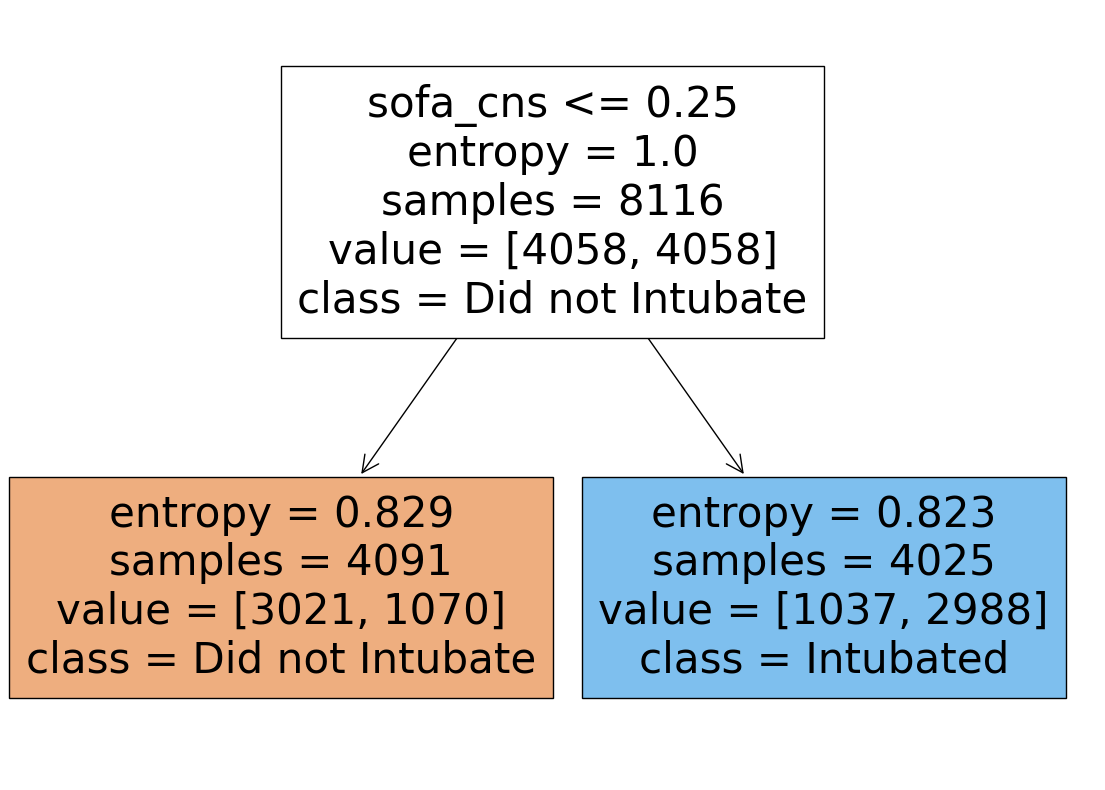

In [43]:
# Splitting rules can be visualized by using plot_tree in sklearn
df_feature_names = list(X_df_SMOTE.columns)

plt.figure(figsize=(14,10))
plot_tree(
    TreeModel,
    filled=True,
    feature_names=df_feature_names,
    class_names=['Did not Intubate','Intubated']
)
plt.show()

In [44]:
# The `max_depth` parameter is important for decision tree.
# We use `GridSearchCV` to select the best `max_depth`.
# If shallow --> tree is easy to explain but the model is not expressive and performance not good
# if large depth --> not easy to explain and may overfit

#try depths from 1 to 10
parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
stratifiedCV = StratifiedKFold(n_splits=8) #uses 8 fold cross validation
TreeModel = DTC(criterion='entropy')

# Gridsearch CV uses cross validation to try a bunch of values for the parameters u are interested it
BestTree = GridSearchCV(
    TreeModel,
    param_grid=parameters,
    scoring='average_precision', # what is the score to use to pick the best parameter
    cv=stratifiedCV #cross validation structure to be used
)
model = BestTree.fit(X_df_SMOTE, y_df_SMOTE)

#this block of code will run cross validation on each possible depth

In [45]:
BestTree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=8)

In [46]:
BestTree.best_score_

0.9380747292167457

In [47]:
y_pred = BestTree.predict(X_df_Test)

auroc_DT = roc_auc_score(y_df_Test,y_pred)
ap_DT = average_precision_score(y_df_Test,y_pred)
f1_DT = f1_score(y_df_Test,y_pred)

print('DT AUC score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_DT,ap_DT,f1_DT))

pd.crosstab(y_df_Test["outcome"],y_pred)

DT AUC score on test dataset: AUROC 0.587, AP 0.098, F1 0.204 


col_0,0,1
outcome,,
0,2288,371
1,145,66


Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':np.arange(start=2,stop=20,step=2),
              'max_depth':np.arange(start=1,stop=10,step=1)}
stratifiedCV = StratifiedKFold(n_splits=8) #uses 8 fold cross validation
RFCTreeModel = RandomForestClassifier(criterion='entropy')

# Gridsearch CV uses cross validation to try a bunch of values for the parameters u are interested it
RFCBestTree = GridSearchCV(
    RFCTreeModel,
    param_grid=parameters,
    scoring='average_precision', # what is the score to use to pick the best parameter
    cv=stratifiedCV #cross validation structure to be used
)
RFCBestTree.fit(X_df_SMOTE, np.ravel(y_df_SMOTE))

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='average_precision')

In [49]:
RFCBestTree.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=18)

In [50]:
RFCBestTree.best_score_

0.9706900707827186

In [51]:
y_pred = RFCBestTree.predict(X_df_Test)

auroc_RFC = roc_auc_score(y_df_Test,y_pred)
ap_RFC = average_precision_score(y_df_Test,y_pred)
f1_RFC = f1_score(y_df_Test,y_pred)

print('RFC AUC score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_RFC,ap_RFC,f1_RFC))

pd.crosstab(y_df_Test["outcome"],y_pred)

RFC AUC score on test dataset: AUROC 0.628, AP 0.118, F1 0.253 


col_0,0,1
outcome,,
0,2305,354
1,129,82


XGBoost Tree Model

XGBoost on balanced dataset

In [52]:
from xgboost import XGBClassifier as XGBC

In [53]:
parameters = {
    'n_estimators':np.arange(start=2,stop=20,step=2),
    'max_depth':np.arange(start=2,stop=6,step=1),
    'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
}
stratifiedCV = StratifiedKFold(n_splits=8)
# XGBC: XGBoost classifier
XGBoostModel = XGBC()
BestXGBoost = GridSearchCV(
    XGBoostModel,
    param_grid=parameters,
    scoring='average_precision',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestXGBoost.fit(X_df_SMOTE,np.ravel(y_df_SMOTE))

Fitting 8 folds for each of 252 candidates, totalling 2016 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'max_depth': array([2, 3, 4, 5]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='average_precision', verbose=1)

In [54]:
BestXGBoost.best_params_

{'learning_rate': 0.35000000000000003, 'max_depth': 5, 'n_estimators': 18}

In [55]:
BestXGBoost.best_score_

0.9872203640650375

In [56]:
y_pred = BestXGBoost.predict(X_df_Test)

auroc_XGB = roc_auc_score(y_df_Test,y_pred)
ap_XGB = average_precision_score(y_df_Test,y_pred)
f1_XGB = f1_score(y_df_Test,y_pred)

print('XGB AUC score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_XGB,ap_XGB,f1_XGB))

pd.crosstab(y_df_Test["outcome"],y_pred)

XGB AUC score on test dataset: AUROC 0.567, AP 0.099, F1 0.199 


col_0,0,1
outcome,,
0,2498,161
1,170,41


Adaboost

In [57]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
parameters = {
    'n_estimators':np.arange(start=2,stop=20,step=2),
    'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
}
stratifiedCV = StratifiedKFold(n_splits=8)

AdaModel = AdaBoostClassifier()

BestAdaModel = GridSearchCV(
    estimator = AdaModel,
    param_grid=parameters,
    scoring='average_precision',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)

BestAdaModel.fit(X_df_SMOTE,np.ravel(y_df_SMOTE))

Fitting 8 folds for each of 63 candidates, totalling 504 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='average_precision', verbose=1)

In [59]:
BestAdaModel.best_params_

{'learning_rate': 0.35000000000000003, 'n_estimators': 18}

In [60]:
BestAdaModel.best_score_

0.8285323787897951

In [61]:
y_pred = BestAdaModel.predict(X_df_Test)

auroc_AB = roc_auc_score(y_df_Test,y_pred)
ap_AB = average_precision_score(y_df_Test,y_pred)
f1_AB = f1_score(y_df_Test,y_pred)

print('AB AUC score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_AB,ap_AB,f1_AB))

pd.crosstab(y_df_Test["outcome"],y_pred)

AB AUC score on test dataset: AUROC 0.692, AP 0.134, F1 0.267 


col_0,0,1
outcome,,
0,2015,644
1,79,132


# SVM

Linear SVM

In [62]:
from sklearn.svm import SVC

In [63]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.
parameters = {
    'C':np.arange(start=1,stop=20,step=5)
}
stratifiedCV = StratifiedKFold(n_splits=8)
SVCModel = SVC(kernel='linear')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='average_precision',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(X_df_SMOTE,np.ravel(y_df_SMOTE))

Fitting 8 folds for each of 4 candidates, totalling 32 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([ 1,  6, 11, 16])},
             scoring='average_precision', verbose=1)

In [64]:
BestSVC.best_estimator_

SVC(C=1, kernel='linear')

In [65]:
BestSVC.best_score_

0.731078879491803

In [71]:
y_pred = BestSVC.predict(X_df_Test)

auroc_SVM = roc_auc_score(y_df_Test,y_pred)
ap_SVM = average_precision_score(y_df_Test,y_pred)
f1_SVM = f1_score(y_df_Test,y_pred)

print('SVM score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_SVM,ap_SVM,f1_SVM))

pd.crosstab(y_df_Test["outcome"],y_pred)

SVM score on test dataset: AUROC 0.683, AP 0.127, F1 0.251 


col_0,0,1
outcome,,
0,1931,728
1,76,135


Non-linear SVM

In [ ]:
parameters = {
    'C':np.arange(start=1,stop=20,step=5)
}
stratifiedCV = StratifiedKFold(n_splits=8)
SVMrbfModel = SVC(kernel='rbf')
BestSVMrbf = GridSearchCV(
    SVMrbfModel,
    param_grid=parameters,
    scoring='average_precision',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVMrbf.fit(X_df_SMOTE,np.ravel(y_df_SMOTE))

Fitting 8 folds for each of 4 candidates, totalling 32 fits


In [ ]:
BestSVMrbf.best_estimator_

In [ ]:
BestSVMrbf.best_score_

In [72]:
y_pred = BestSVMrbf.predict(X_df_Test)

auroc_SVMrbf = roc_auc_score(y_df_Test,y_pred)
ap_SVMrbf = average_precision_score(y_df_Test,y_pred)
f1_SVMrbf = f1_score(y_df_Test,y_pred)

print('SVM score on test dataset: AUROC {:.3f}, AP {:.3f}, F1 {:.3f} '.format(auroc_SVMrbf,ap_SVMrbf,f1_SVMrbf))

pd.crosstab(y_df_Test["outcome"],y_pred)

SVM score on test dataset: AUROC 0.537, AP 0.083, F1 0.142 


col_0,0,1
outcome,,
0,2478,181
1,181,30
